### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 16
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
params = {'freq': 40}

for p in [SysParams_NTSC]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5


In [21]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

m20ire = iretohz(-20)

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [22]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [23]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # mostly used for internal tests, but the exact opposite of the above
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(1, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fcburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz'] * .95)/freq_half, (SP['fsc_mhz'] * 1.05)/freq_half], btype='bandpass')) 
    else:
        SP['Fcburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fcburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [24]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    return np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    #return out_video, out_video05, out_videoburst

In [25]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [26]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [27]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [28]:
def demod(infile, _start, _end, filterset):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        infile.seek(i * sampletype, 0)
        inbuf = infile.read(blocklen * sampletype)
        
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen )
            break
    
        tmp = dodemod(filterset, indata, usemtf=True)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    return output

In [29]:
if True: # DD 3.0 beta fantasia example
    params['freq'] = 44.0
    deemp_adj1 = .55
    deemp_adj2 = .55
    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)
    sampletype = 2

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 4

else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)

#infile = open('/home/cpage/ldcaps/ggv1069-22000.raw', 'rb')
infile = open('/home/cpage/ldcaps/vs44_46500.raw', 'rb')
#tmp= demod(infile, 50000, 2000000, filterset)

In [30]:
import time

t1 = time.time()
tmp= demod(infile, 1100000, 2000000, filterset)
time.time() - t1

1099488 2000000 900512


0.41439270973205566

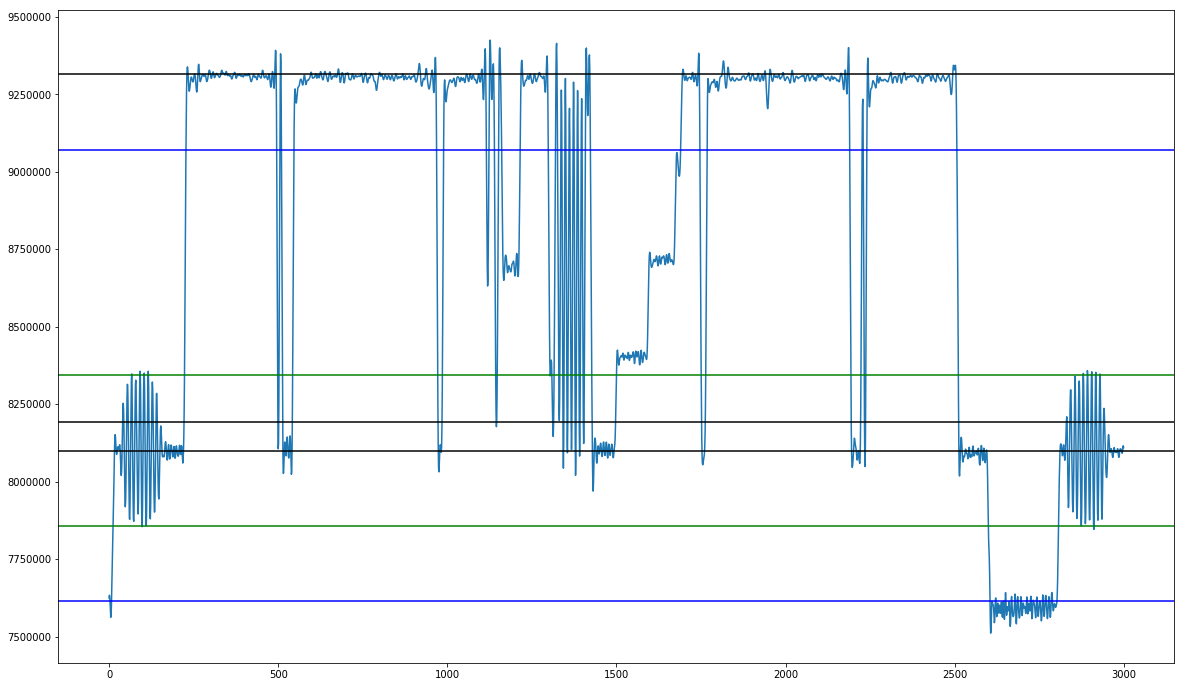

In [31]:
lineplot(tmp['demod'][595000:598000], filterset)


In [32]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [33]:
def genwave(rate, freq):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = 0
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out
    
    

In [34]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_05gap(filterset):
    fakeoutput = np.zeros(blocklen, dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    [tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)

    tmp = np.fft.fft(fakeoutput)
    #tmp3 = tmp2 * filterset['Fdeemp']
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    gap = calczc(fakedecode['demod_05'], 1250, iretohz(-20), 500) - calczc(fakedecode['demod'], 1250, iretohz(-20), 500)
    return gap

In [41]:
filterset['gap05'] = calc_05gap(filterset)

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [42]:
output = tmp['demod']
output_sync = tmp['demod_sync']
output_lp = tmp['demod_05']

In [164]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        #endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
        endsync1 = center + np.where(syncf[center:center + scanarea] > .95)[0][-1]
        print(endsync1)
        endsync = endsync1 + np.where(syncf[endsync1:endsync1 + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')
        return None

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .6)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        print(endsync)
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .6)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    print(lastlinepresync, nextline, presync_eqlen, postsync_eqlen)
    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

findburstfromsync(rdata['demod_sync'], 190301)

193105
193605
173970 201826 4.00591267001 3.50237652112


(173970, 201826, 4.0059126700071577, 3.5023765211166786)

In [157]:
ilinepx = int(filterset['line_px'])

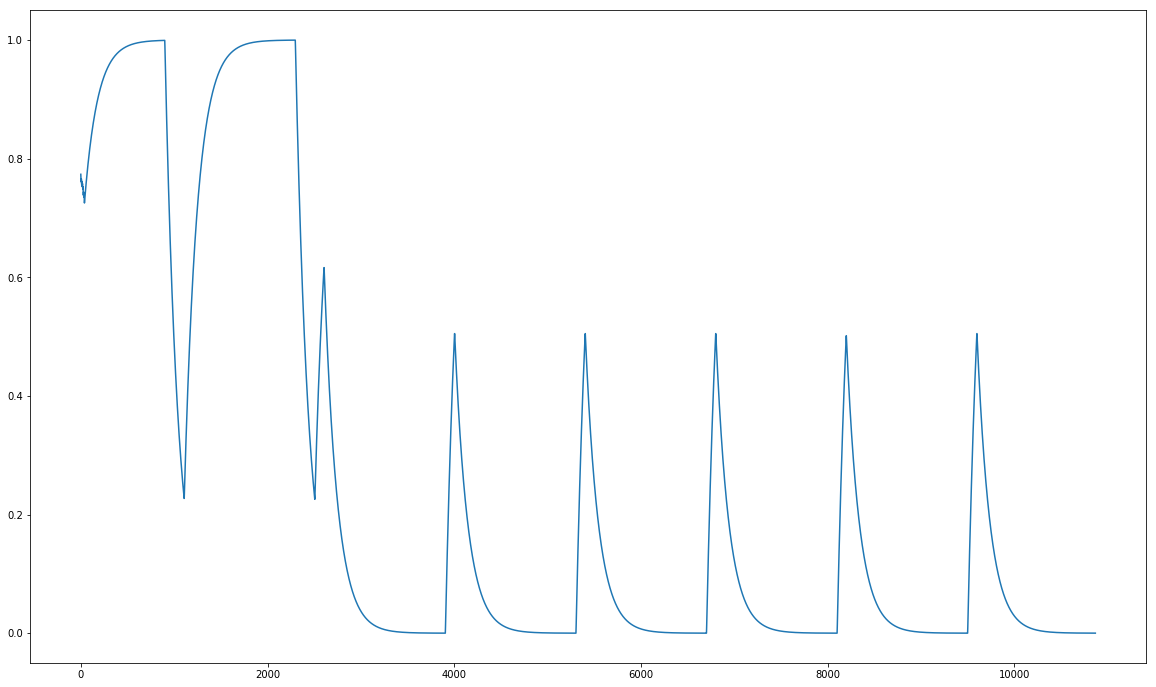

In [162]:
plt.plot(rdata['demod_sync'][190801: 190492 + (ilinepx * 4)])

In [129]:
def findsync(output_sync, loc = 0):
    loc = 0

    # find the next sync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

    if np.max(output_sync[loc:loc+imglen]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None, None)
    
    rv = findburstfromsync(output_sync, syncloc)
    if rv is None:
        return None, None, None
    
    prevline, nextline, pregap, postgap = rv

    print(np.max(output_sync[loc:loc+imglen]), pregap, postgap)
    
    if pregap < 3.75:
        firstfield = True
    else:
        firstfield = False
    
    return syncloc, firstfield, nextline

In [139]:
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

def findfirstframe(infile):
    readlen = int(128 * filterset['line_px'])

    loc = 0
    while loc < filterset['freq_hz']:
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and not firstfield:
            loc += int(240 * filterset['line_px'])
            return loc + nextline, data
        elif syncloc and firstfield:
            return loc + nextline, data
    
    return None

In [140]:
d, rdata = findfirstframe(infile)

0 357632 357632
334768 692912 358144
335280 0.999841493195 0.0913324297098
173970 190620 4.00591267001 0.605812455261
0.999841493195 4.00591267001 0.605812455261
335280 525581 False 0.999841493195 0.0913324297098


In [132]:
test = demod(infile, 0, 1000000, filterset)

0 1000000 1000000


In [141]:
190620-173970

16650

In [147]:
findsync(rdata['demod_sync'], 0)

173970 190620 4.00591267001 0.605812455261
0.999841493195 4.00591267001 0.605812455261


(190301, False, 190620)

In [153]:
findburstfromsync(rdata['demod_sync'], 190301)

173970 190620 4.00591267001 0.605812455261


(173970, 190620, 4.0059126700071577, 0.60581245526127425)

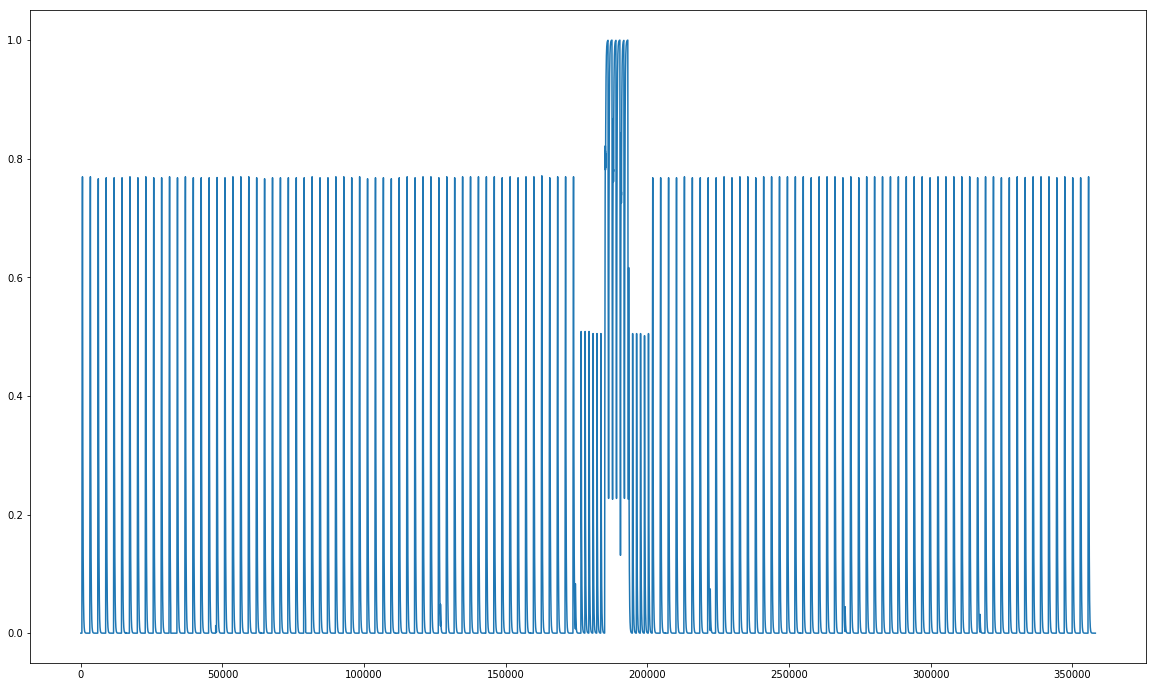

In [146]:
#plt.plot(outputa['demod'])
plt.plot(rdata['demod_sync'])

In [47]:
d

1270104

In [48]:
frame = demod(infile, d - int(20 * filterset['line_px']), d + int(545 * filterset['line_px']), filterset)

1213712 2792834 1579122


In [49]:
syncloc1, firstfield, line1 = findsync(frame['demod_sync'][0:int(24 * filterset['line_px'])], 0)
syncloc2, firstfield, line2 = findsync(frame['demod_sync'][int(250 * filterset['line_px']):int(290 * filterset['line_px'])], 0)
syncloc2 += int(250 * filterset['line_px'])
line2 += int(250 * filterset['line_px'])

0.999841494332
0.999841825375


In [50]:
line1, line2

(55880, 791003)

In [51]:
output = frame['demod']
output_sync = frame['demod_sync']
output_lp = frame['demod_05']

In [52]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
curloc = line1

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
#    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)


In [54]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20) 
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc - filterset['gap05'])
    print(l, zc, output[l], output[l + 1], output[l + 2])
    


58769 58779.0181366 7768562.9926 7856992.88979 7958089.45895
61564 61575.2897947 7751817.80968 7809574.91517 7869131.06116
64361 64372.0708521 7790870.4043 7861078.61585 7920635.62684
67158 67168.5206834 7793985.51622 7866166.38501 7941100.02472
69953 69964.9831984 7757842.04387 7797907.93028 7841210.21875
72750 72761.393971 7738913.3762 7807283.0745 7886772.09329
75547 75557.8354527 7781554.46882 7837522.09754 7914325.53648
78343 78353.958137 7778862.61042 7849006.40929 7927483.05436
81138 81150.1751648 7724053.8217 7836399.6938 7932358.90226
83935 83946.5932114 7781672.24329 7859381.39221 7928384.39163
86732 86742.7839859 7760084.04808 7833966.59061 7924032.30938
89528 89538.9312978 7778831.81575 7854498.0938 7933909.98747
92324 92334.7653455 7794158.20875 7881248.29164 7965033.5716
95119 95130.6618249 7743947.85698 7804504.91597 7874600.29362
97916 97926.9872428 7757821.77201 7840064.42293 7933763.74361
100711 100722.647545 7741757.07232 7809434.58488 7885355.87303
103507 103518.708

In [55]:
# now to get fine sync!

In [56]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [68]:
def downscale_field(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        try:
            scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
            sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)
        except:
            scaled = scale(data, lineinfo[l], lineinfo[l + 1], 910)
            sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

In [58]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [59]:
def calcerr(subset):
    black = np.mean(subset)
    
    subseta = np.abs(subset - black)
    
    peaks = np.where(subseta > 140000)[0]
    toffset = 0
    noffsets = 0

    for p in range(0, len(peaks) - 1):
        if np.abs(subseta[peaks[p]] - subseta[peaks[p + 1]]) < 25000:
            zp = calczc(subset, peaks[p], black)

            if zp is not None:
                #print(peaks[p], subset[peaks[p]] - 8100000, zp, (zp - peaks[p] - 0))

                offset = (zp - peaks[p] - 1)
                toffset += offset
                noffsets += 1
            else:
                offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [60]:
# first pass: check hsyncs and color burst quality.  Any spikes in either will cause
# the line to be ignored and location interpolated.

lineinfo_tmp = lineinfo2.copy()
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
badburst = np.zeros_like(lineinfo_tmp)
finalsnr = []

for l in range(1, len(lineinfo2) - 1):
    # hsync check
    scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
    subset = scaled[850:910]
    if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
        badburst[l] = 1
    
    # color burst check
    #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    subset = scaled[5:60]
    
    #print(l, np.min(subset), np.max(subset))
    if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
        badburst[l] = 1

for l in range(1, len(lineinfo2) - 1):
    print(l, '_', lineinfo_tmp[l], lineinfo_tmp[l + 1])
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if not badburst[l]:
            offset1 = calcerr(scaled[5:60])
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * .5)
        else:
            offset1 = None
        if not badburst[l + 1]:
            offset2 = calcerr(scaled[915:970])
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * .5)
        else:
            offset2 = None
            
        print(l, i, lineinfo_tmp[l], lineinfo_tmp[l + 1], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
#        if l == 51:
#            break
        
        try:
            if np.abs(offset1) < .005 and np.abs(offset2) < .005:
                break
        except:
            None

#    if l == 51:
#        break   

            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
#    print(lineinfo_tmp[l + 1], lineinfo3[l][1])
    lineinfo_tmp[l + 1] = lineinfo2[l + 1]

    

1 _ 58764.8628961 61561.1345542
1 0 58765.2877721 61561.7082178 0.27653758426 0.373378470747 37.3963830428
1 1 58765.4909331 61562.0274374 0.132223684115 0.207758335923 38.9256083444
1 2 58765.5468335 61562.1569981 0.0363802412129 0.0843187758261 39.2929063318
1 3 58765.5641266 61562.184695 0.0112541661537 0.0180247982918 39.0019625639
1 4 58765.5698053 61562.1935099 0.00369565327893 0.00573662241954 38.9343391508
1 f -0.0258704772646 -0.00549671049881 38.9127471485
2 _ 61561.1345542 64357.9156116
2 0 61561.7019948 64358.377688 0.369260840191 0.300695330922 35.6689833314
2 1 61562.0204259 64358.5810507 0.20722625545 0.132342898175 36.5652546461
2 2 61562.1538452 64358.6586338 0.0868292148932 0.0504910052669 37.1268108312
2 3 61562.185897 64358.7050819 0.0208597331199 0.0302289984376 37.2016363534
2 4 61562.19607 64358.7194083 0.00662068516347 0.00932376577921 37.1869854867
2 f -0.00539262725996 0.057452060305 37.1808068919
3 _ 64357.9156116 67154.3654429
3 0 64358.3824255 67154.8003303

25 3 125870.262005 128665.649281 0.00660880255573 0.00243969264415 37.2726327821
25 4 125870.265375 128665.650673 0.00219406221743 0.000905869353693 37.2535259605
25 f 0.0791151298283 0.0609273730385 37.247220634
26 _ 128665.53055 131460.931937
26 0 128665.610507 131461.092423 0.0520577005468 0.10448776294 35.5796842565
26 1 128665.635744 131461.151519 0.0164307063598 0.0384741331355 35.508362048
26 2 128665.643623 131461.170207 0.00512927690015 0.0121668283936 35.4208116977
26 3 128665.646078 131461.176012 0.00159842939589 0.00377943640603 35.386222735
26 f 0.0610441691745 0.000704604162745 35.3748786451
27 _ 131460.931937 134256.063585
27 0 131461.097999 134256.26405 0.108128187056 0.130529211477 35.6740764518
27 1 131461.16005 134256.343165 0.0404032055164 0.0515133856412 35.7456291615
27 2 131461.180029 134256.372302 0.0130088923949 0.0189720104291 35.76721706
27 3 131461.186278 134256.381249 0.00406860529799 0.00582497721827 35.7760611251
27 4 131461.188232 134256.383931 0.0012722

47 _ 187358.572491 190153.217339
47 0 187359.129904 190153.733832 0.363012824318 0.336364177435 34.414338196
47 1 187359.328706 190153.98806 0.129471055878 0.165567270212 34.3822930558
47 2 187359.398734 190154.092159 0.0456050296167 0.0677937278742 34.3896494896
47 3 187359.421111 190154.12652 0.0145725256966 0.0223765963212 34.3584480613
47 4 187359.427877 190154.136906 0.00440649043732 0.00676397054604 34.3411657109
47 f -0.0125565071255 -0.128264844137 34.3353192152
48 _ 190153.217339 192947.588367
48 0 190153.738495 192948.10111 0.339433896533 0.333954084198 35.4846124627
48 1 190153.994552 192948.398316 0.166773087167 0.193574003424 35.4463817411
48 2 190154.099952 192948.507106 0.0686468586134 0.0708547972805 35.5887393537
48 3 190154.135528 192948.538412 0.0231711892237 0.0203898247145 35.6061220707
48 4 190154.146659 192948.554357 0.00724957633653 0.0103850501909 35.5989325146
48 f -0.127475850379 0.0121126762572 35.6116765959
49 _ 192947.588367 195742.256226
49 0 192948.09704

69 3 248836.870312 251631.204257 0.0039416942486 0.01565689355 38.87124088
69 4 248836.883037 251631.209862 0.00828800511072 0.00365089281462 38.879768605
69 f -0.0153026655353 -0.0154877137472 38.8814541312
70 _ 251630.343081 254424.70745
70 0 251630.830912 254425.112364 0.317729716693 0.263724532244 37.6946623115
70 1 251631.078848 254425.300676 0.161488193715 0.122653389135 38.0041384815
70 2 251631.178863 254425.366498 0.0651440068006 0.0428730050589 38.0286442916
70 3 251631.206566 254425.385962 0.0180445932434 0.0126777614459 37.9525907959
70 4 251631.213601 254425.391553 0.00458191148721 0.00364173295728 37.926522951
70 f -0.0148952106473 0.07876720632 37.9220857484
71 _ 254424.70745 257218.912564
71 0 254425.114679 257219.372668 0.265247292925 0.299687287821 37.3169843119
71 1 254425.302014 257219.566762 0.122018293041 0.126420564658 37.3444834992
71 2 254425.365958 257219.635595 0.0416491817975 0.0448333402288 37.3686811674
71 3 254425.38398 257219.659407 0.0117382988268 0.015

89 1 304722.931808 307517.094639 0.0622721595041 0.10870454654 37.8708809583
89 2 304722.960429 307517.178365 0.0186425729689 0.0545357754502 38.6457181622
89 3 304722.968146 307517.20721 0.00502629190842 0.0187879152314 39.1148303961
89 4 304722.970077 307517.23174 0.00125804587875 0.0159771039058 39.2515989778
89 f 0.00358372911018 0.0493857831136 39.3665790882
90 _ 307516.457987 310310.782629
90 0 307516.920636 310311.214454 0.301332046783 0.281255828091 38.1185363889
90 1 307517.087757 310311.431864 0.108850969387 0.14160553863 38.1568490722
90 2 307517.172053 310311.512294 0.0549030848579 0.0523854180446 38.0256058717
90 3 307517.202343 310311.53115 0.0197283741494 0.0122812334028 38.04787275
90 4 307517.213292 310311.536793 0.00713114890292 0.00367530125687 38.0916865316
90 f 0.0556790179907 -0.0191771082169 38.1094664083
91 _ 310310.782629 313105.168029
91 0 310311.213582 313105.588992 0.280682025135 0.274175661298 39.1455144555
91 1 310311.429937 313105.783831 0.140913619971 0.

109 f -0.0105848312421 0.00862392704598 37.2590730894
110 _ 363407.383045 366202.308169
110 0 363407.823723 366202.629815 0.286960844334 0.209449412632 35.2069619748
110 1 363408.048935 366202.786653 0.146659738418 0.102134147333 36.1657019501
110 2 363408.117893 366202.844753 0.0449068142714 0.0378359612282 36.5727452032
110 3 363408.148238 366202.864737 0.0197620443844 0.0130146681889 36.6296982073
110 4 363408.16135 366202.871695 0.00853864058506 0.00453073332375 36.674383892
110 f 0.00898521075734 0.102847881975 36.6983230555
111 _ 366202.308169 368996.813044
111 0 366202.63594 368997.272863 0.21346989042 0.299469591982 36.5888419738
111 1 366202.792124 368997.488425 0.101714408363 0.140384696289 37.4260399294
111 2 366202.847446 368997.562758 0.0360275271045 0.0484076452962 37.5618829065
111 3 366202.865876 368997.587163 0.0120025324503 0.0158936650089 37.5679649887
111 4 366202.871988 368997.595178 0.00397997655102 0.00521966376335 37.5660689918
111 f 0.102614945407 -0.0263541437

133 2 427686.30561 430480.964841 0.0420052333807 0.0512884888561 37.0482134186
133 3 427686.325564 430480.988229 0.0129954153413 0.0152313426561 37.028485103
133 4 427686.33138 430480.995327 0.00378720961612 0.00462265709296 37.0222151949
133 f 0.0113735092137 -0.00854022155973 37.0199375271
134 _ 430480.296757 433275.116753
134 0 430480.711848 433275.454639 0.270309201215 0.220032791414 37.6940964495
134 1 430480.883277 433275.585695 0.111638275537 0.0853470550059 38.0697852809
134 2 430480.962817 433275.62969 0.0517989291232 0.0286508447528 38.1543101939
134 3 430480.987455 433275.644017 0.0160449438457 0.00933044291902 38.1628333412
134 4 430480.995214 433275.648642 0.00505337380816 0.0030115965947 38.152605364
134 f -0.00834316472712 0.0273296694671 38.1483668141
135 _ 433275.116753 436069.412602
135 0 433275.462964 436069.904424 0.225496366177 0.320337281431 35.5773990005
135 1 433275.594182 436070.194345 0.0854614773597 0.188823566327 37.6499286544
135 2 433275.634349 436070.2820

153 1 483579.012491 486373.768527 0.0907603329297 0.115872890202 38.8374244357
153 2 483579.062528 486373.830616 0.0325850804028 0.0404337090812 38.8986274702
153 3 483579.079238 486373.850547 0.010881842791 0.0129793175237 38.898487309
153 4 483579.084675 486373.856668 0.00354056073022 0.0039863235811 38.8972522669
153 f 0.0442911658853 0.0156182783792 38.8971688551
154 _ 486373.188454 489167.871781
154 0 486373.589903 489168.237871 0.261437881148 0.238411467794 37.6842529175
154 1 486373.769487 489168.418312 0.116953140928 0.117511208682 37.6857987209
154 2 486373.833009 489168.487327 0.0413687479955 0.0449457168541 37.6864691564
154 3 486373.853578 489168.509906 0.0133950047911 0.0147041313468 37.6882285707
154 4 486373.859929 489168.51704 0.00413653046651 0.00464582958394 37.6886728929
154 f 0.0155567291076 -0.0378461358257 37.6887416038
155 _ 489167.871781 491962.56595
155 0 489168.237705 491962.88128 0.238302400401 0.205354227792 36.2730803475
155 1 489168.418336 491963.053727 0.

175 f -0.0195545678079 0.0550967127362 39.5218520906
176 _ 547856.911586 550651.707455
176 0 547857.299492 550652.120223 0.252608564624 0.268799126426 40.5847620151
176 1 547857.469232 550652.325731 0.110535377663 0.133827374783 40.5784982032
176 2 547857.526118 550652.410582 0.0370439144338 0.0552551609197 40.7525697936
176 3 547857.538758 550652.437166 0.00823106257682 0.0173106471285 40.8426905094
176 4 547857.542115 550652.445317 0.00218628484497 0.00530795872826 40.8624724014
176 f 0.0549710044115 0.0402816560818 40.8648347331
177 _ 550651.707455 553446.727764
177 0 550652.116845 553447.154341 0.26657774225 0.277769121856 39.1136989317
177 1 550652.320353 553447.338226 0.132514908087 0.119737635677 39.0451141561
177 2 550652.405337 553447.401067 0.0553385499012 0.0409197547035 39.1484042007
177 3 550652.433023 553447.420881 0.0180275663723 0.0129019231643 39.2230535369
177 4 550652.442004 553447.427129 0.00584833720934 0.0040685502423 39.2413831022
177 f 0.0406914009373 0.00914112

194 f 0.00634345897352 -0.000461101979791 39.4588086985
195 _ 600962.732225 603758.154626
195 0 600963.106346 603758.273518 0.243577205228 0.0774065223329 35.5893353611
195 1 600963.273611 603758.323394 0.108910289044 0.0324753401192 38.0928391269
195 2 600963.329206 603758.34322 0.0362009148355 0.01290985035 38.5051737592
195 3 600963.345839 603758.350674 0.0108301706966 0.0048537618886 38.4778335757
195 4 600963.350685 603758.353365 0.00315596072063 0.00175198436018 38.4597264372
195 f -0.000176183528492 0.0216582533457 38.4551246902
196 _ 603758.154626 606553.211638
196 0 603758.279004 606553.538667 0.08098867288 0.212945205709 36.2032731378
196 1 603758.323913 606553.68106 0.0292402388864 0.0927123655645 38.0263334081
196 2 603758.338279 606553.742376 0.00935395373499 0.0399216200998 38.3395687709
196 3 603758.34241 606553.760848 0.00268919898405 0.0120262428206 38.2972357219
196 4 603758.343563 606553.76631 0.000750707614772 0.00355612594169 38.2590974025
196 f 0.0209447447995 0.0

216 f 0.136322857725 -0.0185268555276 34.4225197755
217 _ 662463.12034 665259.0055
217 0 662463.580097 665259.356843 0.299281596799 0.228709036973 36.3202527451
217 1 662463.788033 665259.519775 0.135362394239 0.10606600514 36.8224332924
217 2 662463.890735 665259.57852 0.0668582543213 0.0382419138035 36.8917153188
217 3 662463.924955 665259.598003 0.0222773460031 0.0126836194084 36.892442038
217 4 662463.936012 665259.604315 0.00719804309968 0.00410913714125 36.8748512623
217 f -0.0183973731962 0.00690565001996 36.8672925681
218 _ 665259.0055 668054.665093
218 0 665259.360004 668055.063308 0.230785276925 0.25924184899 38.4611126863
218 1 665259.522219 668055.228517 0.105601900806 0.107551029668 38.9240625506
218 2 665259.579795 668055.289556 0.0374815095956 0.0397364965376 38.9768689443
218 3 665259.597979 668055.309576 0.0118382403917 0.0130325754046 39.0026392216
218 4 665259.603563 668055.316108 0.00363518775906 0.00425233303233 39.013954634
218 f 0.00661158834998 0.0308995723416 3

240 4 726772.627806 729569.054415 0.00189109340042 0.00230281083903 38.3953822425
240 f -0.0192240928681 -0.0133934456855 38.3957789086
241 _ 729568.623846 732364.855075
241 0 729568.890067 732365.171933 0.17327679788 0.206235346624 38.1928166816
241 1 729569.007059 732365.295667 0.0761461343652 0.0805341451407 38.2112340424
241 2 729569.043714 732365.333908 0.0238568944097 0.0248894934926 38.1908159356
241 3 729569.055113 732365.366173 0.00741950320832 0.0210005324627 38.1843629374
241 4 729569.058235 732365.374962 0.00203221106187 0.0057202708665 38.1498619391
241 f -0.0136404075331 -0.0336446306201 38.1362268312
242 _ 732364.855075 735161.274775
242 0 732365.168735 735161.516521 0.204140181147 0.157336189387 37.7199082477
242 1 732365.29322 735161.620066 0.0810208004493 0.0673923375312 37.9129787401
242 2 732365.332336 735161.661618 0.0254588316758 0.0270445767096 37.9280812189
242 3 732365.364825 735161.674211 0.0211459232459 0.00819612483403 37.9393792044
242 4 732365.374615 73516

In [61]:
offset1 = calcerr(scaled[5:60])
offset2 = calcerr(scaled[915:970])
offset1, offset2

(0.0015013969598262572, 0.00047410703333241602)

In [62]:
np.mean(finalsnr)

37.983241208082411

In [63]:
finalsnr = [] 
for i in range(1, len(lineinfo2) - 1):
    if badburst[i] and not (badburst[i - 1] or badburst[i + 1]):
        print(i, lineinfo3[i - 1], lineinfo3[i], lineinfo3[i + 1])
        print((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)
        lineinfo3[i] = ((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2, lineinfo3[i][1])
        lineinfo3[i - 1] = (lineinfo3[i - 1][0], (lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)

    linelen = lineinfo3[i][1] - lineinfo3[i][0]
    line12end = lineinfo3[i][0] + (linelen * 1.2)
        
    scaled = scale(output, lineinfo3[i][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(i, 'f', lineinfo3[i][0] - lineinfo2[i], lineinfo3[i][0] - lineinfo3[i-1][1], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 f 0.706909203822 -3.43019465049 -0.0258704772646 -0.00549671049881 38.9127471485
2 f 1.06151578834 0.00256011867168 -0.00539262725996 0.057452060305 37.1808068919
3 f 0.807563415343 0.00376673509163 0.0575986143104 0.00194680036811 37.0734602969
4 f 0.749255327901 -0.00266012293287 0.0015149220624 -0.00922704280295 37.8317538353
5 f 0.792795780202 0.00524728435266 -0.00908496855477 0.15731719349 38.177047333
6 f 0.706128396443 0.00264539622003 0.157295711513 0.00916266741407 36.8393145644
7 f 0.495447903173 -0.00116574201093 0.00912446992044 0.0893355258218 36.5774574851
8 f 0.648487568076 0.00102902494837 0.0891636293699 -0.00392012235498 38.1054672174
9 f 0.68526701571 -0.00155963300494 -0.00377421540203 -0.0511937093256 38.4959329242
10 f 0.569326576267 0.00741472597292 -0.0515379743294 -0.015561987391 38.1081282333
11 f 0.397117538916 -0.000706926934072 -0.0158914427311 0.00391812278008 39.66380162
12 f 0.314223226247 -0.000469786304166 0.00417608137952 0.0540269417139 38.3384248

219 f 0.646290383069 -0.00472494633868 0.0308433137002 -0.0477546932178 38.8245590515
220 f 0.831810613861 0.00332167954184 -0.0473574117385 -0.0112892490924 35.4683681885
221 f 0.58315149846 0.00144500925671 -0.0119887419259 -0.0524861439228 39.0625734943
222 f 0.84827981994 -0.00821701274253 -0.0520571401841 -0.0190914494094 36.872352658
223 f 0.60999995959 0.00810350198299 -0.0201123079247 -0.0102913832629 39.3515061662
224 f 0.736180211534 -0.00751517759636 -0.00967089260958 0.0292471317376 40.2786968909
225 f 0.577842462342 0.00706766557414 0.0282963411663 -0.0216123180802 39.0081337719
226 f 0.536186485318 0.0190937272273 -0.0232028136096 0.311687750541 32.5121019637
227 (687626.33276280714, 690421.65593300038) (690421.65593300038, 693218.15309833002) (693218.16575386585, 696014.29343764484)
690422.249258
227 f 0.593325336115 0.0 0.0712142147223 0.0940521607989 36.349596546
228 f 0.552532487782 0.0126555358293 0.0861928647982 0.024237380137 35.4420491359
229 f 0.709474637173 0.00

In [64]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr) + 1

(38.002556676393731, 21.400733930074605, 249)

38.0025566764
(230230,)
uint8 (253, 910) (253, 910)


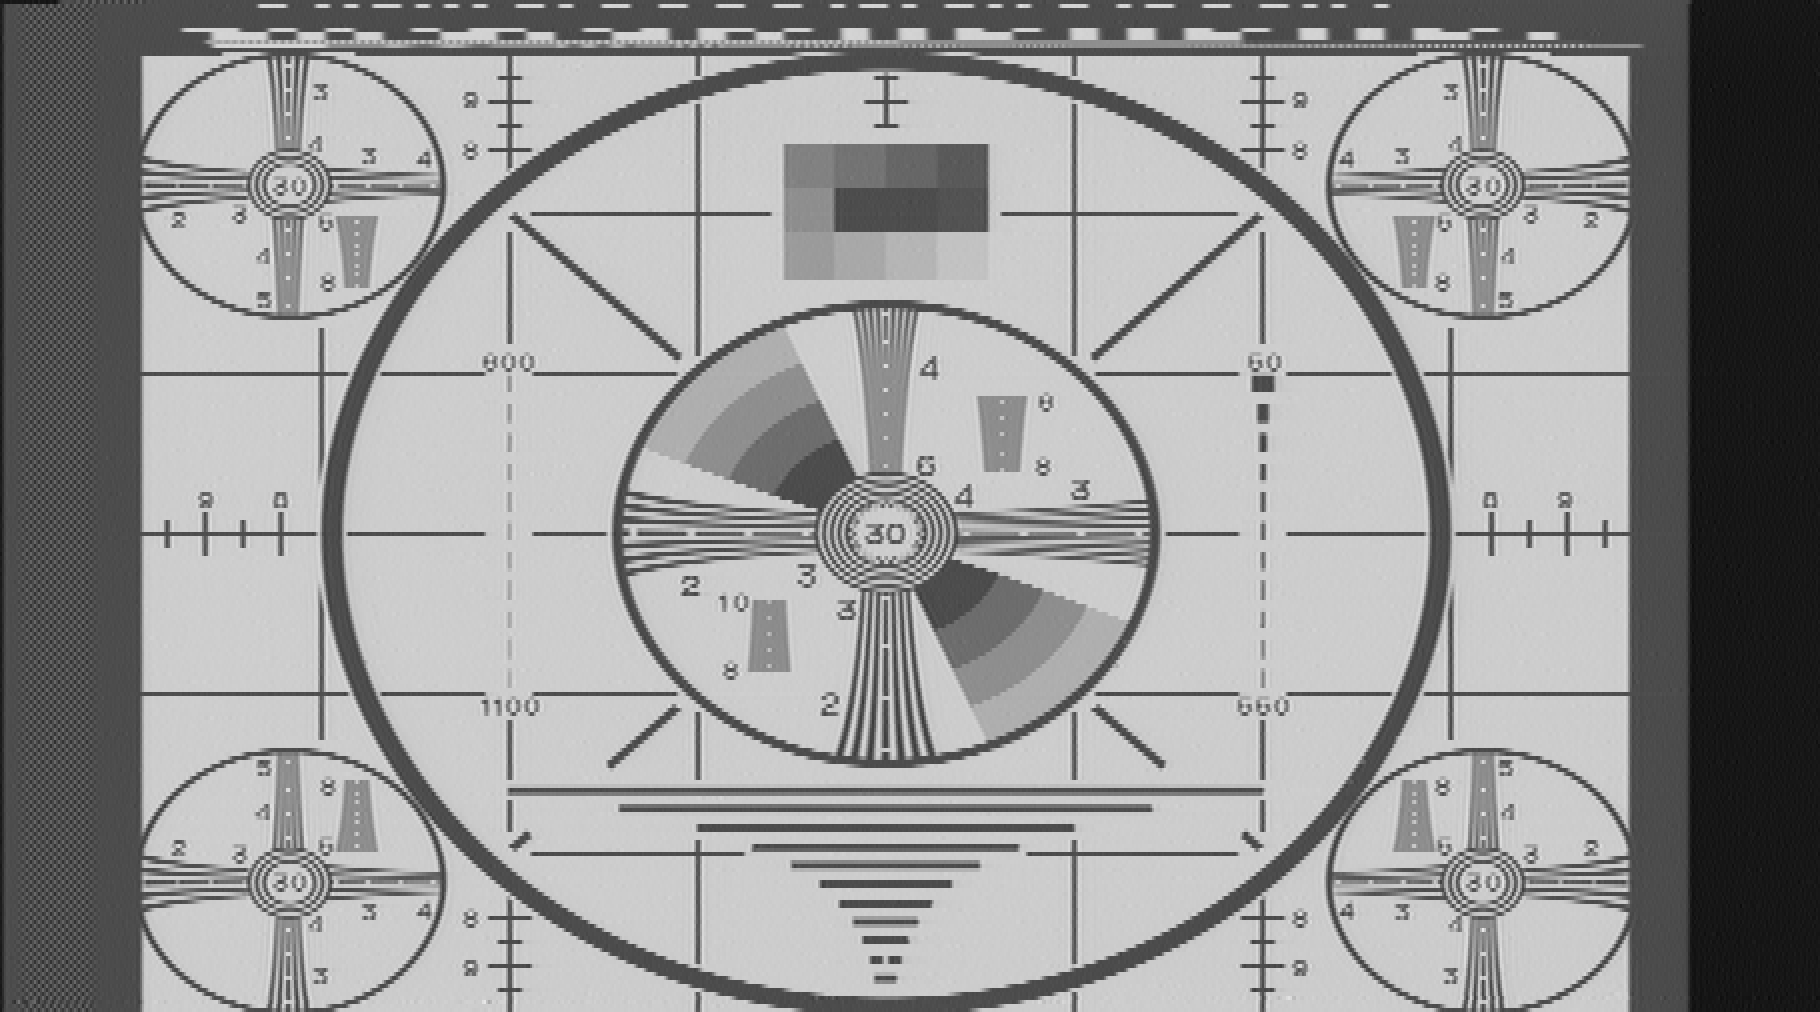

In [69]:
print(np.mean(finalsnr))
lines, sfactor = downscale_field(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

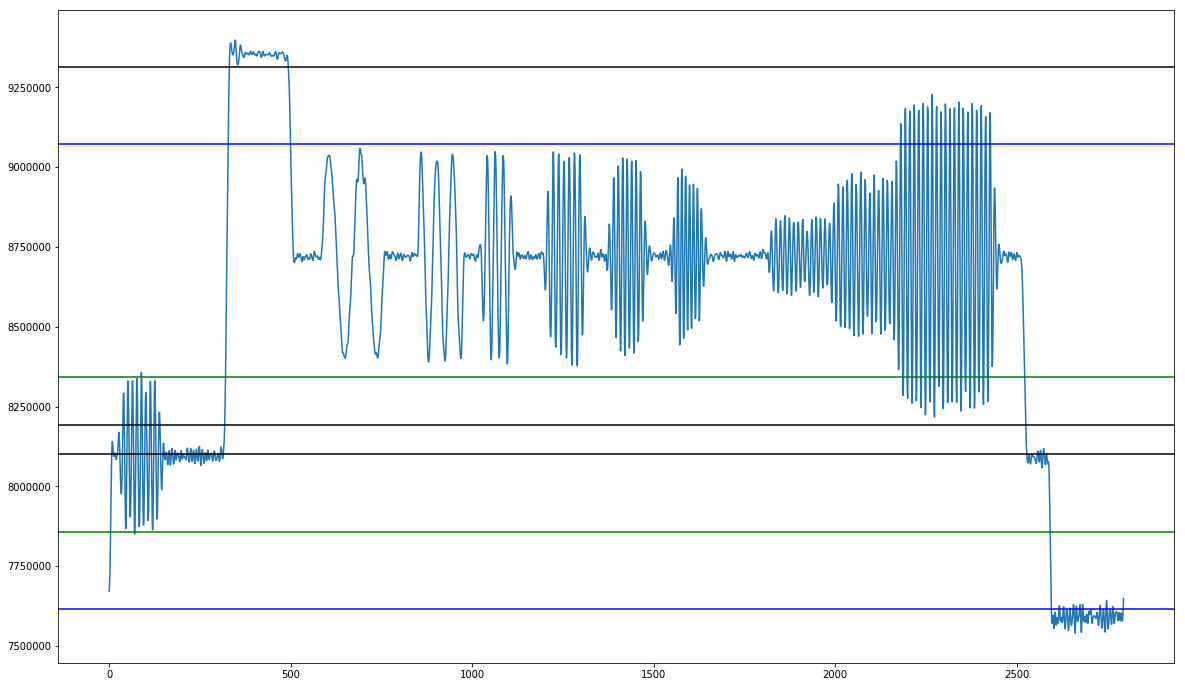

In [66]:
l = 11
x = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
lineplot(x, filterset)

#l = 28
#y = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
#lineplot(y[20:110], filterset)


(37.881372439035836, 21.403009239761598)

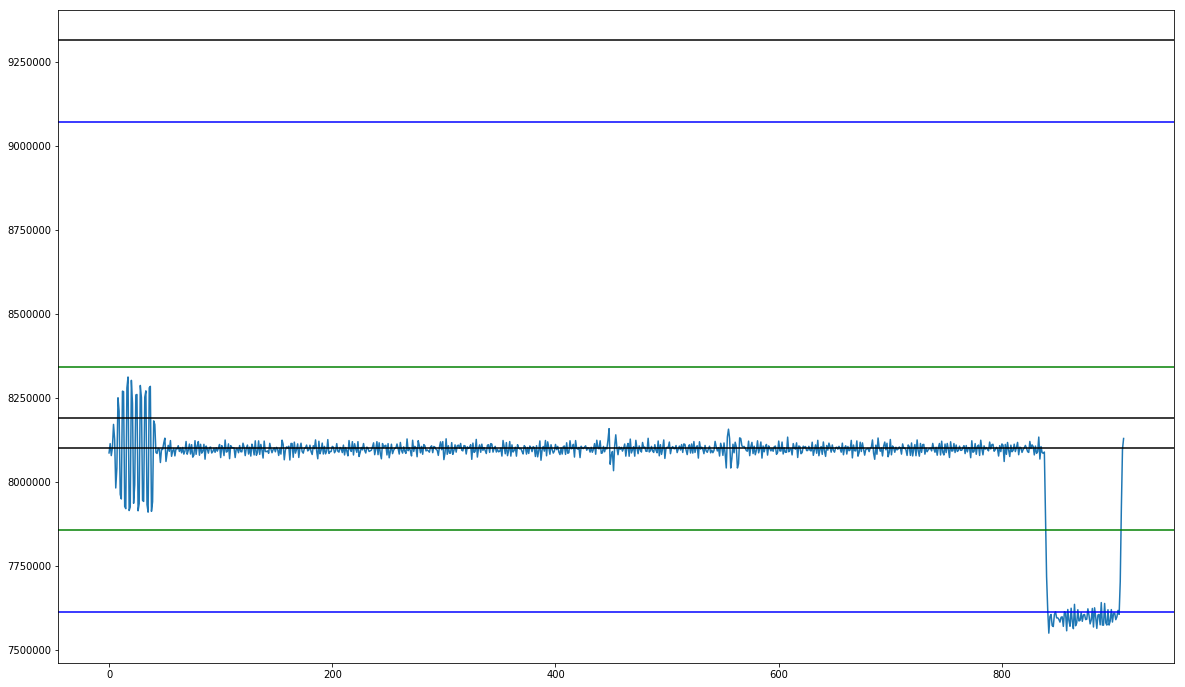

In [69]:
l = 5
x = lines[l * 910:(l + 1) * 910]
lineplot(x, filterset)
calcsnr(x[200:700]), calcsnr(x[850:])

In [62]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 0.0805832080497 842.860427005 909.850746834 40.1075826986
3 -0.149253166001 842.847391766 909.887333621 43.3194978334
4 -0.112666378753 842.761096314 909.883849088 41.9545766983
5 -0.116150911731 842.800224486 909.872527231 43.9049913763
6 -0.127472769063 842.778568666 909.937219462 41.7590875792
7 -0.0627805383294 842.787742189 909.894528978 36.9566969411
8 -0.105471021659 842.910504162 909.923849414 43.8605534011
9 -0.0761505859211 842.869424675 910.024761655 37.940036852
10 0.0247616552646 842.855020548 909.879673424 40.0829737051
11 -0.120326576213 842.753162521 910.013278818 42.7996418037
12 0.0132788180625 842.771407221 909.772877988 41.7411444344
13 -0.227122011923 842.806638544 909.867482287 38.5153419859
14 -0.132517712543 842.851041429 909.878833554 41.8054572892
15 -0.121166446014 842.740352631 909.767992423 39.6318106659
16 -0.232007576529 842.788309388 909.959515557 41.4724716013
17 -0.0404844431786 842.807360215 909.879363483 38.1410615583
18 -0.120636516683 842.8139285

204 0.0546714456993 842.870419527 909.883177544 42.0503951189
205 -0.116822456108 842.785649026 910.007901959 38.633170322
206 0.0079019594973 842.76552314 909.982697574 41.0399514219
207 -0.0173024263377 842.856450784 909.987169034 40.001413557
208 -0.0128309655823 842.788242349 909.904253938 41.6839928281
209 -0.095746062178 842.794264122 909.896187439 42.5350879347
210 -0.103812560961 842.783855943 910.028363498 40.3760537534
211 0.0283634979736 842.791803319 909.794632918 38.6556539534
212 -0.205367082444 842.876495368 909.915618566 41.7806777628
213 -0.0843814338397 842.854662638 909.962761677 42.9676890061
214 -0.0372383229385 842.796937299 909.846190734 41.1671817022
215 -0.153809265737 842.79843558 909.944067149 41.3072516805
216 -0.0559328512906 842.743517747 909.87452612 41.2238620344
217 -0.125473879614 842.813102272 909.850199137 40.1114414468
218 -0.149800862565 842.772007575 910.031036109 40.6795409071
219 0.0310361092518 842.835296167 909.910939539 43.3357683303
220 -0.0

In [63]:
np.mean(zclen), np.std(zclen)

(67.118102313399547, 0.084296795301364968)

In [64]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.081186212859014034, 0.052871247228317909, 41.119441712221381)

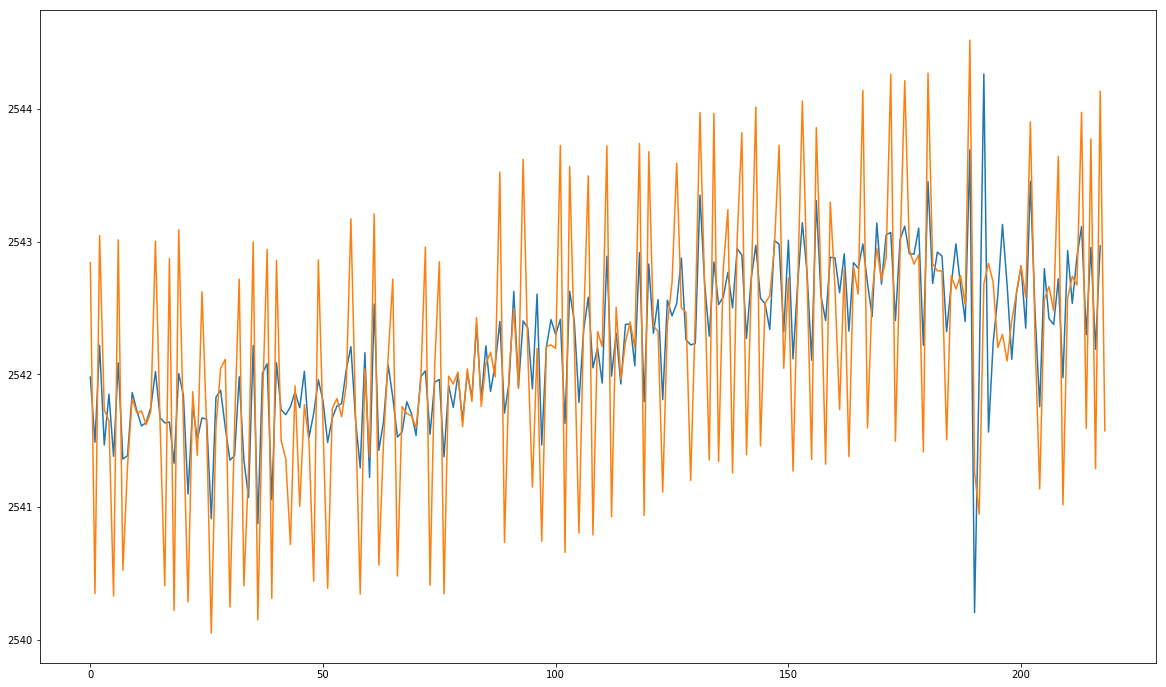

In [376]:
# tbc effectiveness check - line length.  lineinfo3 is pretty even
plt.plot(np.diff(lineinfo2[1:220]))
plt.plot(np.diff(lineinfo3[1:220]))